In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import usr_func

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


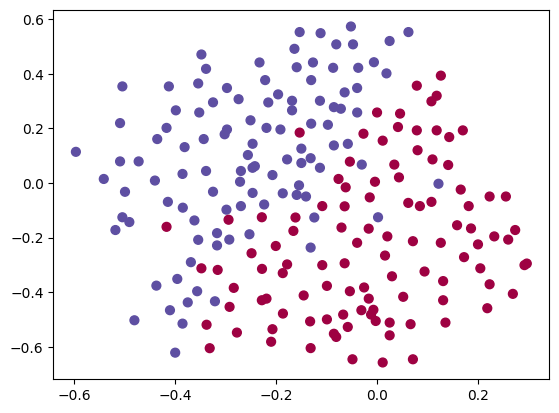

In [11]:
x_train, y_train, x_test, y_test = usr_func.load_2d_dataset()
plt.scatter(x_train[0, :], x_train[1, :], c=y_train, s=40, cmap=plt.cm.Spectral)

In [34]:
def model(X, Y, learning_rate=.3, num_iterations=30000, print_cost=True, lambd=0, keep_prob=1): 
    grads = {}
    costs = []
    m = X.shape[1]
    layers_dims = [X.shape[0], 20, 3, 1]
    
    parameters = usr_func.initialize_parameters(layers_dims)
    
    for i in range(0, num_iterations):
        if keep_prob == 1:
            a3, cache = usr_func.forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        if lambd == 0:
            cost = usr_func.compute_loss(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
        
        assert(lambd == 0 or keep_prob == 1)
        
        if lambd == 0 and keep_prob == 1:
            grads = usr_func.backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        parameters = usr_func.update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

def compute_cost_with_regularization(A3, Y, parameters, lambd): 
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = usr_func.compute_loss(A3, Y)
    
    L2_regularization_cost = lambd * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))) / (2 * m)
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

def backward_propagation_with_regularization(X, Y, cache, lambd): 
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    dW3 = 1./m * np.dot(dZ3, A2.T) + lambd * W3 / m
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))  
    dW2 = 1./m * np.dot(dZ2, A1.T) + lambd * W2 / m
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T) + lambd * W1 / m
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3, "dA2": dA2, 
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    return gradients

def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5): 
    np.random.seed(1)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = usr_func.relu(Z1)
    D1 = np.random.rand(A1.shape[0], A1.shape[1])
    D1 = (D1 < keep_prob).astype(int)
    A1 = np.multiply(A1, D1)
    A1 = A1 / keep_prob
    
    Z2 = np.dot(W2, A1) + b2
    A2 = usr_func.relu(Z2)
    D2 = np.random.rand(A2.shape[0], A2.shape[1])
    D2 = (D2 < keep_prob).astype(int)
    A2 = np.multiply(A2, D2)
    A2 = A2 / keep_prob
    
    Z3 = np.dot(W3, A2) + b3
    A3 = usr_func.sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

def backward_propagation_with_dropout(X, Y, cache, keep_prob): 
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)
    
    dA2 = np.multiply(dA2, D2)
    dA2 = dA2 / keep_prob
    
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    
    dA1 = np.multiply(dA1, D1)
    dA1 = dA1 / keep_prob
    
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3, "dA2": dA2, 
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

Cost after iteration 0: 0.6543912405149825


c:\Users\nq9093\CodeSpace\DeepLearningAI\DeepLearning\C2-HyperparameterTuning\w1\usr_func.py:69: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
c:\Users\nq9093\CodeSpace\DeepLearningAI\DeepLearning\C2-HyperparameterTuning\w1\usr_func.py:69: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Cost after iteration 10000: 0.0610169865749056
Cost after iteration 20000: 0.060582435798513114


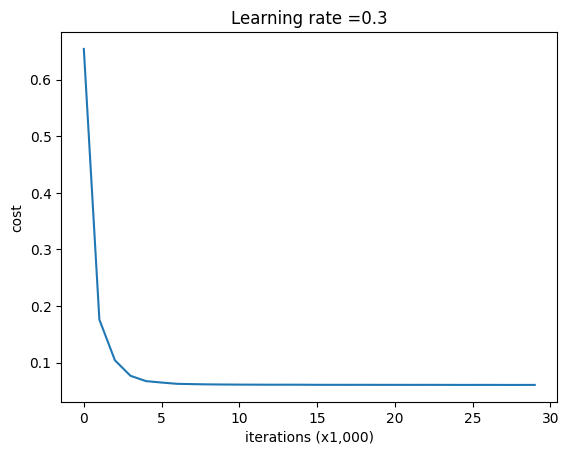

On the training set:
Accuracy: 0.9289099526066351
On the test set:
Accuracy: 0.95


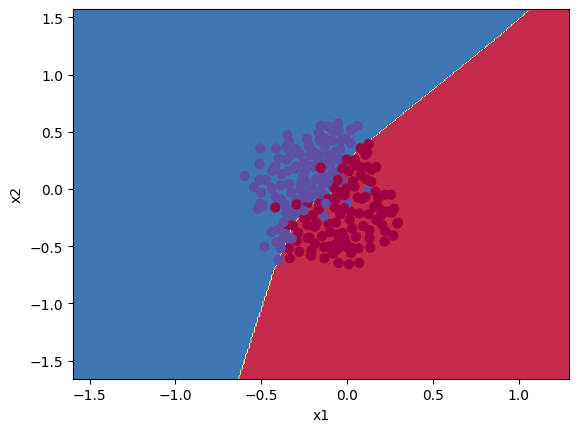

In [35]:
parameters = model(x_train, y_train, keep_prob=.86, learning_rate=.3)
print("On the training set:")
predictions_train = usr_func.predict(x_train, y_train, parameters)
print("On the test set:")
predictions_test = usr_func.predict(x_test, y_test, parameters)


x_min, x_max = x_train[0, :].min() - 1, x_train[0, :].max() + 1
y_min, y_max = x_train[1, :].min() - 1, x_train[1, :].max() + 1
h = 0.01

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
a3, _ = usr_func.forward_propagation(np.c_[xx.ravel(), yy.ravel()].T, parameters)
pred = (a3 > 0.5).astype(int) 
Z = pred.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
plt.ylabel('x2')
plt.xlabel('x1')
plt.scatter(x_train[0, :], x_train[1, :], c=y_train, s=40, cmap=plt.cm.Spectral)
plt.show()